In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

1) 데이터 로드하기

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x18bea329b80>)

In [90]:
# 훈련데이터 테스트 데이터 저장
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [91]:
# train_dta에 존재하는 영화 리뷰 갯수 확인
print('훈련용 리뷰 개수 :', len(train_data))

훈련용 리뷰 개수 : 150000


In [92]:
train_data.head()

id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1

In [93]:
print('테스트용 리뷰 개수: ', len(test_data))

테스트용 리뷰 개수:  50000


In [94]:
test_data.head()

id                                           document  label
0  6270596                                                굳 ㅋ      1
1  9274899                               GDNTOPCLASSINTHECLUB      0
2  8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3  6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4  6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0

2) 데이터 정제하기

In [95]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [96]:
# 중복 샘플 제거하기
train_data.drop_duplicates(subset=['document'], inplace=True)

In [97]:
len(train_data)

146183

<Axes: xlabel='label'>

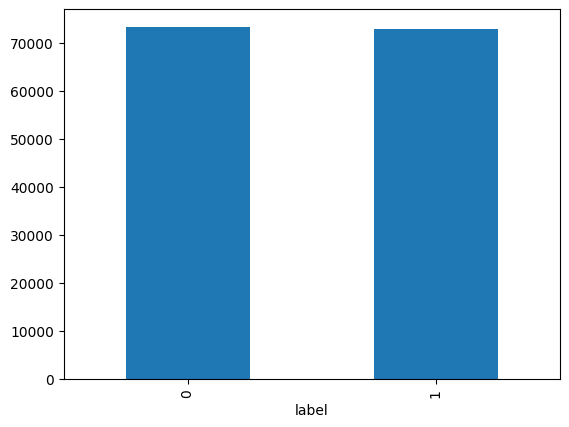

In [98]:
# 긍정 부정 레이블 값 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [99]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  73342
1      1  72841


In [100]:
# null값 확인하기
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [101]:
train_data.loc[train_data.document.isnull()]

id document  label
25857  2172111      NaN      1

In [102]:
# null값 행 삭제하기
train_data = train_data.dropna(how='any')
print(train_data.isnull().values.any())

False


In [103]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [104]:
# 전처리 _ 특수문자 등 한글만 남기고 제거하기. 
# 정규 표현식 사용
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

id                                           document  label
0   9976970                                  아 더빙 진짜 짜증나네요 목소리      0
1   3819312                         흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                          교도소 이야기구먼 솔직히 재미는 없다평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...      1

In [105]:
# 공백만 있거나 빈값을 가진 행이 있다면 null값으로 변경하고 확인
train_data['document'] = train_data['document'].str.replace('^ +', "",regex=True)

In [106]:
train_data['document'].replace('', np.nan, inplace=True)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\1594716675.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [107]:
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [108]:
train_data.loc[train_data.document.isnull()][:5]

id document  label
404   4221289      NaN      0
412   9509970      NaN      1
470  10147571      NaN      1
584   7117896      NaN      0
593   6478189      NaN      0

In [109]:
train_data = train_data.dropna(how='any')

In [110]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145393 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        145393 non-null  int64 
 1   document  145393 non-null  object
 2   label     145393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.4+ MB


In [111]:
#  테스트 데이터 전처리
test_data.drop_duplicates(subset=['document'], inplace=True)

In [112]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)

In [113]:
test_data['document'] = test_data['document'].str.replace('^ +', "", regex= True)

In [114]:
test_data['document'].replace('', np.nan, inplace=True)

In [115]:
test_data = test_data.dropna(how= 'any')

In [116]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48852 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        48852 non-null  int64 
 1   document  48852 non-null  object
 2   label     48852 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


3)토큰화

In [117]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [118]:
# Okt를 사용하여 형태소 분석
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [119]:
# train_data 에 형태소 분석기를 사용하여 토큰화, 불용어 제거 후 X_train에 저장하기
# tqdm -> terminal 또는 notebook 자동으로 진행상태를 시각적으로 보여주는 라이브러리
X_train=[]
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [05:40<00:00, 427.00it/s]


In [121]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [122]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem = True)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [02:15<00:00, 359.98it/s]


4) 정수인코딩

In [123]:
# 훈련데이터에 대해서 단어집합 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [124]:
# 단어집합 생성 및 각 단어에 고유 index 부여 확인
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '다': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '로': 17,
 '아니다': 18,
 '않다': 19,
 '점': 20,
 '에서': 21,
 '만들다': 22,
 '나오다': 23,
 '연기': 24,
 '것': 25,
 '평점': 26,
 '내': 27,
 '최고': 28,
 '그': 29,
 '나': 30,
 '안': 31,
 '인': 32,
 '스토리': 33,
 '생각': 34,
 '못': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '감동': 39,
 '사람': 40,
 '보고': 41,
 '이렇다': 42,
 '말': 43,
 '고': 44,
 '아깝다': 45,
 '더': 46,
 '배우': 47,
 '때': 48,
 'ㅋㅋ': 49,
 '아': 50,
 '감독': 51,
 '거': 52,
 '그냥': 53,
 '재미있다': 54,
 '요': 55,
 '재미': 56,
 '시간': 57,
 '내용': 58,
 '뭐': 59,
 '까지': 60,
 '중': 61,
 '주다': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '쓰레기': 67,
 '수': 68,
 '네': 69,
 '모르다': 70,
 '가다': 71,
 '들다': 72,
 '그렇다': 73,
 '싶다': 74,
 '지': 75,
 '작품': 76,
 '사랑': 77,
 '알다': 78,
 '하나': 79,
 '다시': 80,
 '마지막': 81,
 '볼': 82,
 '이건': 83,
 '정도': 84,
 '저': 85,
 '완전': 86,
 '오다': 87,
 'ㅋ': 88,
 'ㅠㅠ': 89,
 '많다': 90,
 '처음': 91,
 'ㅋㅋㅋ': 92,
 '장면': 9

In [126]:
# 빈도수가 낮은 단어들은 자연어 처리에서 배제
# 높은 정수가 부여된 단어-> 등장 빈도수가 매우 낮다는것을 의미. 빈도수가 3회 미만인 단어의 비중 확인

threshold = 3
total_cnt = len(tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 #등장 빈도수가 threshold 보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold 보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value


print('단어 집합의 크기 :',  total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold -1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100 )
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율:', (rare_freq / total_freq)*100)

단어 집합의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [127]:
#  등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
#  전체 단어 개수 중 빈도수 2이하인 단어는 제거, 0번 패딩 토큰을 고려하여 +1
vocab_size = total_cnt -rare_cnt +1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [128]:
#  텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [129]:
X_train[:3]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 2315, 5671, 2, 222, 9]]

In [142]:
len(X_train)

145393

In [130]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

5) 빈 샘플 제거

In [131]:
# 빈도수가 낮은 단어 삭제는 빈 샘플이 되었다는 것이므로 길이가 0인 샘플 따로 저장하여 삭제하기
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [145]:
len(drop_train)

231

In [ ]:
# 빈 샘플 제거 후 의 샘플 개수 확인
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

In [146]:
#X_train에서 빈샘플 제거 하기
X_train = [sample for sample in X_train if len(sample) >0]

In [159]:
y_train = np.delete(y_train, drop_train, axis=0)

In [156]:
len(X_train)

145162

In [160]:
len(y_train)

145162

6) 패딩

리뷰의 최대 길이 :  69
리뷰의 평균 길이 :  10.812485361182679


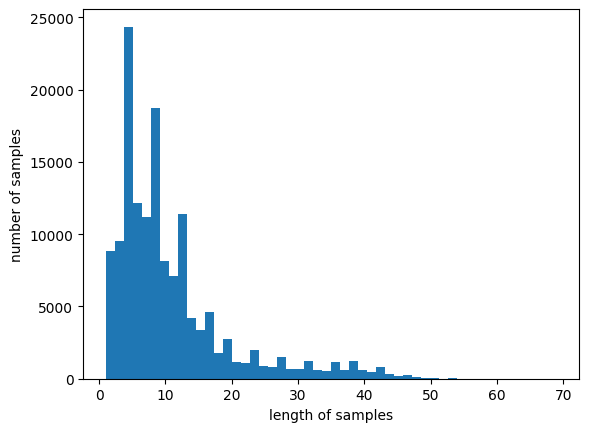

In [161]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업
print('리뷰의 최대 길이 : ', max(len(review) for review in X_train))
print('리뷰의 평균 길이 : ', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins =50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [162]:

# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율 확인
def below_threshold_len(max_len, nested_list):
    count =0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count+1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (count / len(nested_list))*100))

In [163]:
#  max_len을 30 이하인 샘플의 비율 확인
max_len =30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율 : 94.31944999380003


In [164]:
# 모든 샘플의 길이를 30으로 맞추기
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)


2. LSTM으로 네이버 영화 리뷰 감성 분류하기

#이진분류 => 출력층에 로지스틱 회귀 사용. 

#활성화함수 : 시그모이드 함수, 손실함수 : 크로스 엔트로피함수

#하이퍼파라미터인 배치크기 : 64, 에포크 :15

#EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)한다는 의미 

#ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만모델을 저장

#validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인

#검증데이터는 기계가 훈련 데이터에 과적합 되고 있지는 않은지 확인하기 위한 용도로 사용됨.

In [165]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#임베딩 벡터의 차원과 은닉상태의 크기는 자연어 처리 모델에서 매우 중요한 하이퍼파라미이다.

#임베딩 벡터의 차원: 단어를 표현하는 공간의 크기를 결정

#은닉상태의 크기: 모델이 기억할 수 있는 정보의 양을 결정

#일반적으로 임베딩 벡터의 차원이 클수록 단어 간의 의미론적 유사성을 더 잘 캡처할 수 있음.

#임베딩 벡터의 차원이 너무 크면 모델의 파라미터 수가 증가하여 학습 속도가 느려지고 과적합이 발생할 수 있음. 일반적으로 50에서 300 사이의 값을 선택.

#은닉 상태의 크기는 모델의 복잡성을 결정. 은닉 상태의 크기가 클수록 모델이 더 많은 정보를 기억할 수 있지만. 모델의 학습이 더 어려워지고 메모리 사용량이 증가. 일반적으로 64에서 512 사이의 값을 선택

#모델의 성능을 향상시키기 위해서는 임베딩 벡터의 차원과 은닉 상태의 크기를 조정하고 실험하여 최적의 값을 찾아야 함. 여러가지 값을 시도해보고 검증 데이터셋을 사용하여 성능을 평가하는것이 좋다.

In [168]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation ='sigmoid'))

es = EarlyStopping(monitor ='val_loss',mode ='min', verbose =1, patience =4)
mc = ModelCheckpoint('best_model.h5', monitor ='val_acc', mode ='max', verbose =1, save_best_only =True)

model.compile(optimizer ='rmsprop', loss = 'binary_crossentropy', metrics =['acc'])
history = model.fit(X_train, y_train, epochs =15, callbacks =[es, mc], batch_size =64, validation_split =0.2)

Epoch 1/15
1813/1815 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8234
Epoch 1: val_acc improved from -inf to 0.84604, saving model to best_model.h5
1815/1815 [==============================] - 49s 25ms/step - loss: 0.3889 - acc: 0.8234 - val_loss: 0.3501 - val_acc: 0.8460
Epoch 2/15
1814/1815 [============================>.] - ETA: 0s - loss: 0.3263 - acc: 0.8585
Epoch 2: val_acc improved from 0.84604 to 0.85448, saving model to best_model.h5
1815/1815 [==============================] - 38s 21ms/step - loss: 0.3263 - acc: 0.8585 - val_loss: 0.3318 - val_acc: 0.8545
Epoch 3/15
1812/1815 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.8724
Epoch 3: val_acc improved from 0.85448 to 0.85906, saving model to best_model.h5
1815/1815 [==============================] - 44s 24ms/step - loss: 0.3012 - acc: 0.8724 - val_loss: 0.3296 - val_acc: 0.8591
Epoch 4/15
1815/1815 [==============================] - ETA: 0s - loss: 0.2829 - acc: 0.8825
Epoch 4: val_

In [169]:
# 훈련 종료 후 테스트데이터에 대해서 정확도를 측정. 훈련과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5' 로드
loaded_model  = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 9s 5ms/step - loss: 0.3507 - acc: 0.8562

 테스트 정확도: 0.8562


In [170]:
# 토크나이저 파일로 저장 후 로드
with open ('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

with open('tokenizer.pickle','rb') as handle:
    tokenizer = pickle.load(handle)

3. 리뷰 예측해보기

In [171]:
# 임의의 리뷰에 대해서 예측하는 함수 만들기
# 기본적으로 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용.
# model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 함

In [174]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
    new_sentence = okt.morphs(new_sentence, stem = True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어제거
    encoded = tokenizer.texts_to_sequences([new_sentence])  # 정수 인코딩
    pad_new = pad_sequences (encoded, maxlen = max_len)  # 패딩
    score = float(loaded_model.predict(pad_new))  # 예측

    if(score > 0.5):
        print("{:.2f}%  확률로 긍정 리뷰입니다. \n".format(score *100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 -score) * 100))


In [175]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 330ms/step
96.98%  확률로 긍정 리뷰입니다. 



C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\2749718888.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))  # 예측


In [176]:
sentiment_predict('이 영화 핵노잼 ㅋㅋㅋㅋ')

1/1 [==============================] - 0s 20ms/step
98.96% 확률로 부정 리뷰입니다.



C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\2749718888.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))  # 예측


In [177]:
sentiment_predict('이딴 그지같은 영화 왜보냐')

1/1 [==============================] - 0s 31ms/step
99.73% 확률로 부정 리뷰입니다.



C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\2749718888.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))  # 예측


In [178]:
sentiment_predict('감독 머하는 놈이냐 개쩐다 ')

1/1 [==============================] - 0s 16ms/step
81.79% 확률로 부정 리뷰입니다.



C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\2749718888.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))  # 예측


In [179]:
sentiment_predict('개쩐다 ')

1/1 [==============================] - 0s 16ms/step
89.46%  확률로 긍정 리뷰입니다. 



C:\Users\tjoeun\AppData\Local\Temp\ipykernel_260\2749718888.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))  # 예측
